In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../src/")
from Intensity_PDF import *
from Tissue_Fluorophore import Tissue_Fluorophore
from irf_function import IRF
from spectral_sensitivity import SpectralSensitivity
from bias import Bias
import numpy as np
from typing import Tuple
from visualisation_utils import (
    save_data,
    save_peak_intensities,
    save_bias_data,
    plot_peak_intensity_per_channel,
    data_and_irf_inspection,
    single_data_and_irf_inspection,
    get_max_and_average_peak_intensity_per_channel,
    get_peak_intensity_per_channel,
)
from scipy import signal
from scipy import interpolate as interp
import seaborn as sns
from path_vars import IRF_PATH, PDE_PATH

In [3]:
# distribution_locations = "plate-reader-distributions-mirrored"
# # loading elastin, fad, and riboflavin splines
# elastin_spline_info = np.load(f"{distribution_locations}/elastin_spline.npz")
# elastin_bounds = Wavebounds(
#     np.min(elastin_spline_info["x"]), np.max(elastin_spline_info["x"])
# )
# elastin_spline = interp.UnivariateSpline(
#     elastin_spline_info["x"], elastin_spline_info["y"], s=elastin_spline_info["s"]
# )

# fad_spline_info = np.load(f"{distribution_locations}/fad_spline.npz")
# fad_bounds = Wavebounds(np.min(fad_spline_info["x"]), np.max(fad_spline_info["x"]))
# fad_spline = interp.UnivariateSpline(
#     fad_spline_info["x"], fad_spline_info["y"], s=fad_spline_info["s"]
# )

# riboflavin_spline_info = np.load(f"{distribution_locations}/riboflavin_spline.npz")
# riboflavin_bounds = Wavebounds(
#     np.min(riboflavin_spline_info["x"]), np.max(riboflavin_spline_info["x"])
# )
# riboflavin_spline = interp.UnivariateSpline(
#     riboflavin_spline_info["x"],
#     riboflavin_spline_info["y"],
#     s=riboflavin_spline_info["s"],
# )

# # plot the splines
# elastin_x = np.linspace(*elastin_bounds, 1000)
# elastin_y = elastin_spline(elastin_x)

# fad_x = np.linspace(*fad_bounds, 1000)
# fad_y = fad_spline(fad_x)

# riboflavin_x = np.linspace(*riboflavin_bounds, 1000)
# riboflavin_y = riboflavin_spline(riboflavin_x)

# plt.figure()
# sns.lineplot(x=elastin_x, y=elastin_y, label="elastin")
# sns.lineplot(x=fad_x, y=fad_y, label="fad")
# sns.lineplot(x=riboflavin_x, y=riboflavin_y, label="riboflavin")
# plt.xlabel("Wavelength (nm)")
# plt.ylabel("Intensity")
# plt.title("Emission Spectra of Elastin, FAD, and Riboflavin")
# plt.legend()
# plt.show()

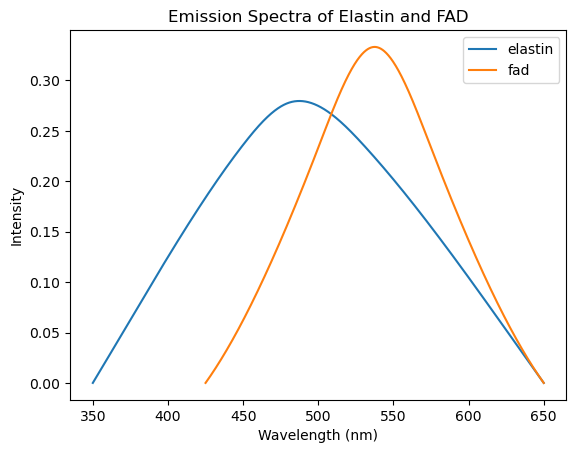

In [4]:
distribution_locations = "../data/endogenous-fluoro-emissions"
# loading elastin and fad splines (riboflavin is same emission as fad for now)
elastin_spline_info = np.load(
    f"{distribution_locations}/left_shifted_elastin_spline.npz"
)
elastin_bounds = Wavebounds(
    np.min(elastin_spline_info["x"]), np.max(elastin_spline_info["x"])
)
elastin_spline = interp.UnivariateSpline(
    elastin_spline_info["x"], elastin_spline_info["y"], s=elastin_spline_info["s"]
)

fad_spline_info = np.load(f"{distribution_locations}/fad_spline.npz")
fad_bounds = Wavebounds(np.min(fad_spline_info["x"]), np.max(fad_spline_info["x"]))
fad_spline = interp.UnivariateSpline(
    fad_spline_info["x"], fad_spline_info["y"], s=fad_spline_info["s"]
)

# plot the splines
elastin_x = np.linspace(*elastin_bounds, 1000)
elastin_y = elastin_spline(elastin_x)

fad_x = np.linspace(*fad_bounds, 1000)
fad_y = fad_spline(fad_x)

plt.figure()
sns.lineplot(x=elastin_x, y=elastin_y, label="elastin")
sns.lineplot(x=fad_x, y=fad_y, label="fad")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("Emission Spectra of Elastin and FAD")
plt.legend()
plt.show()

In [5]:
# defining the IRF and spectral sensitivity
irf = IRF(path=IRF_PATH)
spectral_sensitivity = SpectralSensitivity(
    blue_pde_range=(0, 1), red_pde_range=(0, 1), path=PDE_PATH
)

# defining the tissue fluorophores
elastin = Tissue_Fluorophore(
    elastin_spline,
    elastin_bounds,
    0,
    spectral_sensitivity.red_spad_sensitivity,
    spectral_sensitivity.red_spad_range,
    irf.lookup,
    irf.mu_lookup,
    "Elastin",
)

fad = Tissue_Fluorophore(
    fad_spline,
    fad_bounds,
    0,
    spectral_sensitivity.blue_spad_sensitivity,
    spectral_sensitivity.blue_spad_range,
    irf.lookup,
    irf.mu_lookup,
    "FAD",
)

riboflavin = Tissue_Fluorophore(
    fad_spline,
    fad_bounds,
    0,
    spectral_sensitivity.blue_spad_sensitivity,
    spectral_sensitivity.blue_spad_range,
    irf.lookup,
    irf.mu_lookup,
    "Riboflavin",
)

# Mixture Proportions
|  **Fluoro** | **Mix Percentage (%)** | **Lifetime (ns)** |
|:-----------:|:----------------------:|:-----------------:|
|  FAD  |           60          |        0.5       |
| Riboflavin |           10          |        4.5        |
|   Elastin   |           30         |        1.7        |

As the MuFLE is only able to detect a peak intensity over 300 this means that 

In [6]:
fluoro_concentrations = {"fad": 0.6, "riboflavin": 0.05, "elastin": 0.35}

minimum_peak_intensity = 300
minimum_fluoro_concentration = min(fluoro_concentrations.values())

for fluoro_name in fluoro_concentrations:
    # calculating the ratio
    ratio = fluoro_concentrations[fluoro_name] / minimum_fluoro_concentration
    # calculating the peak intensity
    peak_intensity = ratio * minimum_peak_intensity
    print(f"{fluoro_name} peak intensity: {round(peak_intensity):_}")

fad peak intensity: 3_600
riboflavin peak intensity: 300
elastin peak intensity: 2_100


Max fad intensity: 3712
Avg fad intensity: 1797.552036199095


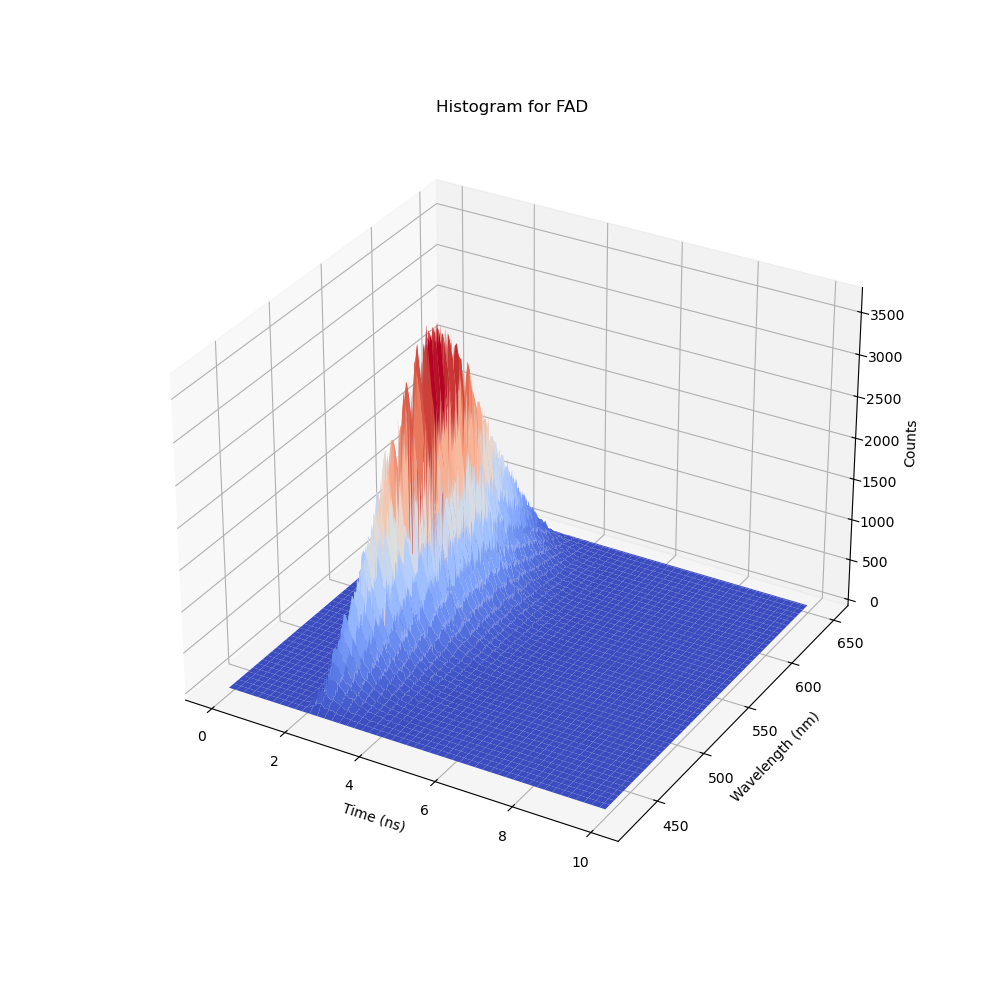

In [7]:
%matplotlib widget
#setting fad config
fad.average_lifetime = 0.5
fad_data = fad.generate_data(11_600_000, use_spectral_sensitivity=False, use_bias=False)
max_fad_intensity, avg_fad_intensity = get_max_and_average_peak_intensity_per_channel(fad_data, fad.bias.get_intensity_matrix_indicies())
print(f"Max fad intensity: {max_fad_intensity}")
print(f"Avg fad intensity: {avg_fad_intensity}")
fad.plot_data(time_range=(0,10))

Max elastin intensity: 807
Avg elastin intensity: 447.37118644067795


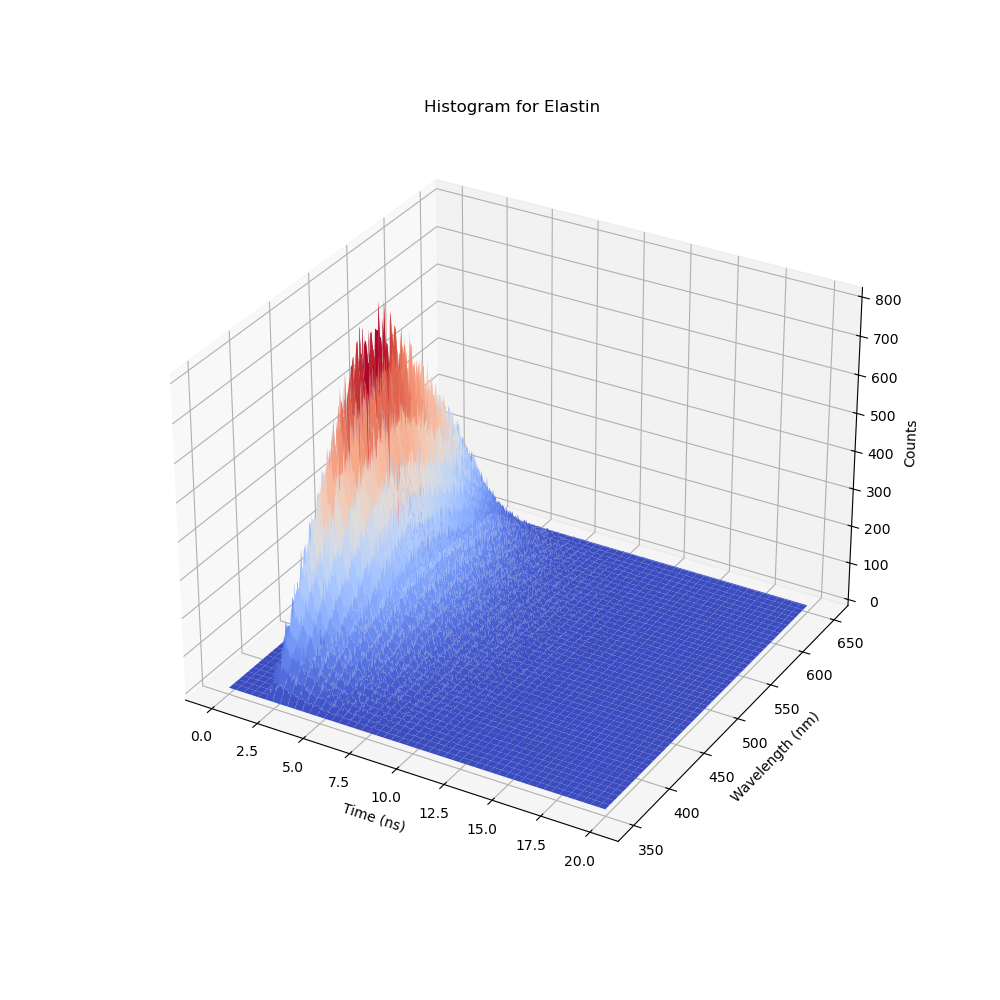

In [8]:
# settings elastin config
elastin.average_lifetime = 1.7
elastin_data = elastin.generate_data(
    10_000_000, use_spectral_sensitivity=False, use_bias=False
)
max_elastin_intensity, avg_elastin_intensity = (
    get_max_and_average_peak_intensity_per_channel(
        elastin_data, elastin.bias.get_intensity_matrix_indicies()
    )
)
print(f"Max elastin intensity: {max_elastin_intensity}")
print(f"Avg elastin intensity: {avg_elastin_intensity}")
elastin.plot_data(time_range=(0, 20))

Max riboflavin intensity: 367
Avg riboflavin intensity: 168.26696832579185


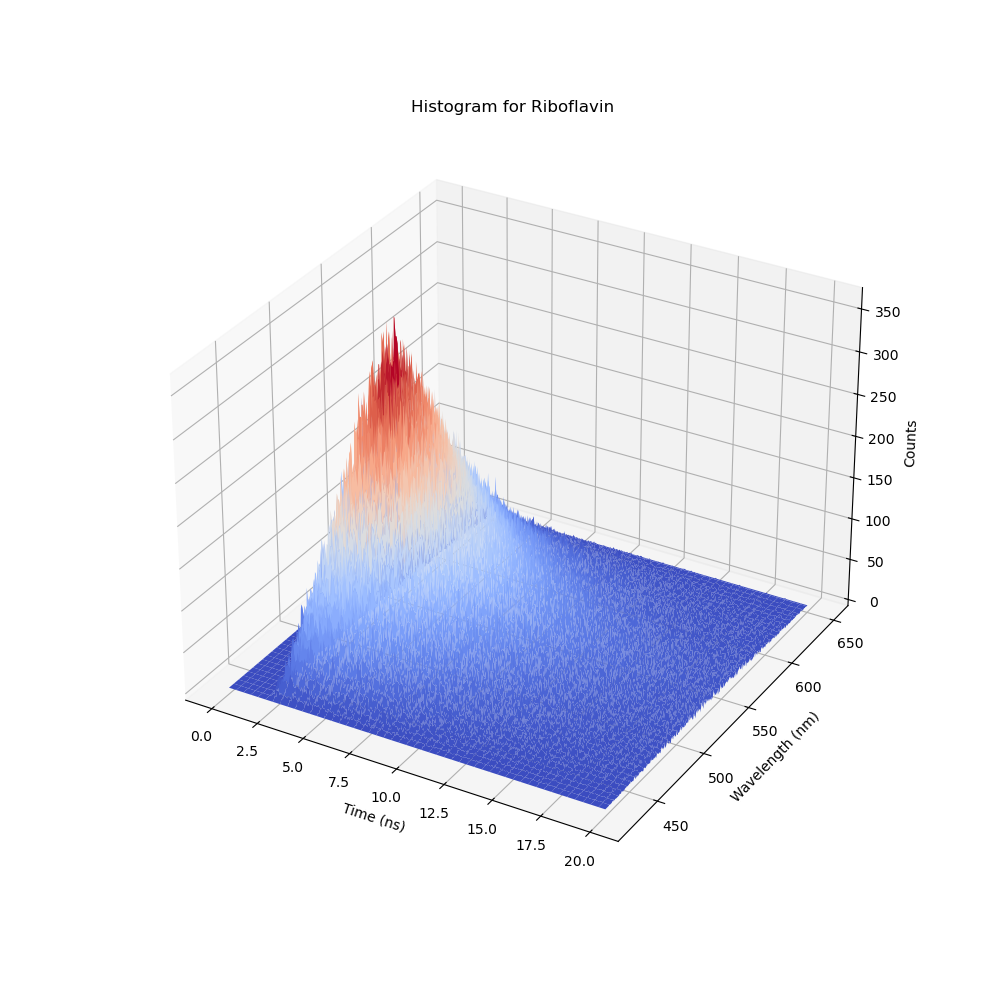

In [9]:
# setting riboflavin config
riboflavin.average_lifetime = 4.5
riboflavin_data = riboflavin.generate_data(
    6_500_000, use_spectral_sensitivity=False, use_bias=False
)
max_riboflavin_intensity, avg_riboflavin_intensity = (
    get_max_and_average_peak_intensity_per_channel(
        riboflavin_data, riboflavin.bias.get_intensity_matrix_indicies()
    )
)
print(f"Max riboflavin intensity: {max_riboflavin_intensity}")
print(f"Avg riboflavin intensity: {avg_riboflavin_intensity}")
riboflavin.plot_data(time_range=(0, 20))

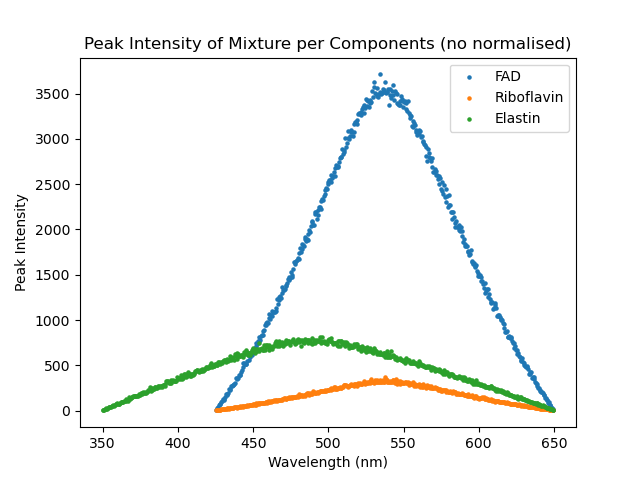

In [10]:
riboflavin_wavelengths, riboflavin_peaks = get_peak_intensity_per_channel(
    riboflavin_data,
    riboflavin.bias.get_intensity_matrix_indicies(),
    with_wavelengths=True,
)
fad_wavelengths, fad_peaks = get_peak_intensity_per_channel(
    fad_data, fad.bias.get_intensity_matrix_indicies(), with_wavelengths=True
)
elastin_wavelengths, elastin_peaks = get_peak_intensity_per_channel(
    elastin_data, elastin.bias.get_intensity_matrix_indicies(), with_wavelengths=True
)


total = np.concatenate((riboflavin_peaks, fad_peaks, elastin_peaks))


riboflavin_peaks_scaled = (riboflavin_peaks - total.min()) / (total.max() - total.min())
fad_peaks_scaled = (fad_peaks - total.min()) / (total.max() - total.min())
elastin_peaks_scaled = (elastin_peaks - total.min()) / (total.max() - total.min())

plt.figure()
# plt.scatter(range(fad_peaks_scaled.shape[0]), fad_peaks_scaled, s=5, label="FAD")
# plt.scatter(range(elastin_peaks_scaled.shape[0]), elastin_peaks_scaled, s=5, label="Elastin")
# plt.scatter(range(riboflavin_peaks_scaled.shape[0]), riboflavin_peaks_scaled, s=5, label="Riboflavin")
plt.scatter(fad_wavelengths, fad_peaks, s=5, label="FAD")
plt.scatter(riboflavin_wavelengths, riboflavin_peaks, s=5, label="Riboflavin")
plt.scatter(elastin_wavelengths, elastin_peaks, s=5, label="Elastin")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Peak Intensity")
plt.title("Peak Intensity of Mixture per Components (no normalised)")
plt.legend()
plt.show()

Sensitivity Range: (355.0, 1123.0)
Channel Range: (300, 1000)


/home/markus/code/fluoro-data-gen/scripts/../src/Tissue_Fluorophore.py:480: UserWarning: The channel range bounds are greater than the spectral sensitivty range, the bounds of the spectral sensitivity will be extended
  warnings.warn(


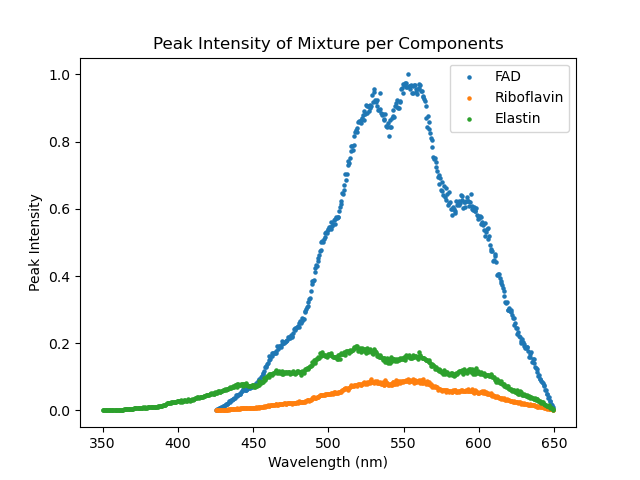

In [11]:
elstin_ss = elastin.get_spectral_sensitivity_matrix()
riboflavin_wavelengths, riboflavin_peaks = get_peak_intensity_per_channel(
    np.round(riboflavin_data * elstin_ss),
    riboflavin.bias.get_intensity_matrix_indicies(),
    with_wavelengths=True,
)
fad_wavelengths, fad_peaks = get_peak_intensity_per_channel(
    np.round(fad_data * elstin_ss),
    fad.bias.get_intensity_matrix_indicies(),
    with_wavelengths=True,
)
elastin_wavelengths, elastin_peaks = get_peak_intensity_per_channel(
    np.round(elastin_data * elstin_ss),
    elastin.bias.get_intensity_matrix_indicies(),
    with_wavelengths=True,
)


total = np.concatenate((riboflavin_peaks, fad_peaks, elastin_peaks))


riboflavin_peaks_scaled = (riboflavin_peaks - total.min()) / (total.max() - total.min())
fad_peaks_scaled = (fad_peaks - total.min()) / (total.max() - total.min())
elastin_peaks_scaled = (elastin_peaks - total.min()) / (total.max() - total.min())

plt.figure()
# plt.scatter(range(fad_peaks_scaled.shape[0]), fad_peaks_scaled, s=5, label="FAD")
# plt.scatter(range(elastin_peaks_scaled.shape[0]), elastin_peaks_scaled, s=5, label="Elastin")
# plt.scatter(range(riboflavin_peaks_scaled.shape[0]), riboflavin_peaks_scaled, s=5, label="Riboflavin")
plt.scatter(fad_wavelengths, fad_peaks_scaled, s=5, label="FAD")
plt.scatter(riboflavin_wavelengths, riboflavin_peaks_scaled, s=5, label="Riboflavin")
plt.scatter(elastin_wavelengths, elastin_peaks_scaled, s=5, label="Elastin")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Peak Intensity")
plt.title("Peak Intensity of Mixture per Components")
plt.legend()
plt.show()

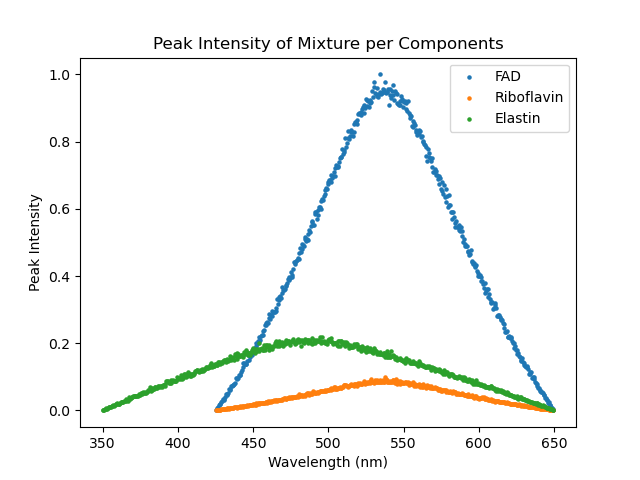

In [12]:
riboflavin_wavelengths, riboflavin_peaks = get_peak_intensity_per_channel(
    riboflavin_data,
    riboflavin.bias.get_intensity_matrix_indicies(),
    with_wavelengths=True,
)
fad_wavelengths, fad_peaks = get_peak_intensity_per_channel(
    fad_data, fad.bias.get_intensity_matrix_indicies(), with_wavelengths=True
)
elastin_wavelengths, elastin_peaks = get_peak_intensity_per_channel(
    elastin_data, elastin.bias.get_intensity_matrix_indicies(), with_wavelengths=True
)


total = np.concatenate((riboflavin_peaks, fad_peaks, elastin_peaks))


riboflavin_peaks_scaled = (riboflavin_peaks - total.min()) / (total.max() - total.min())
fad_peaks_scaled = (fad_peaks - total.min()) / (total.max() - total.min())
elastin_peaks_scaled = (elastin_peaks - total.min()) / (total.max() - total.min())

plt.figure()
# plt.scatter(range(fad_peaks_scaled.shape[0]), fad_peaks_scaled, s=5, label="FAD")
# plt.scatter(range(elastin_peaks_scaled.shape[0]), elastin_peaks_scaled, s=5, label="Elastin")
# plt.scatter(range(riboflavin_peaks_scaled.shape[0]), riboflavin_peaks_scaled, s=5, label="Riboflavin")
plt.scatter(fad_wavelengths, fad_peaks_scaled, s=5, label="FAD")
plt.scatter(riboflavin_wavelengths, riboflavin_peaks_scaled, s=5, label="Riboflavin")
plt.scatter(elastin_wavelengths, elastin_peaks_scaled, s=5, label="Elastin")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Peak Intensity")
plt.title("Peak Intensity of Mixture per Components")
plt.legend()
plt.show()

Sensitivity Range: (355.0, 1123.0)
Channel Range: (300, 1000)


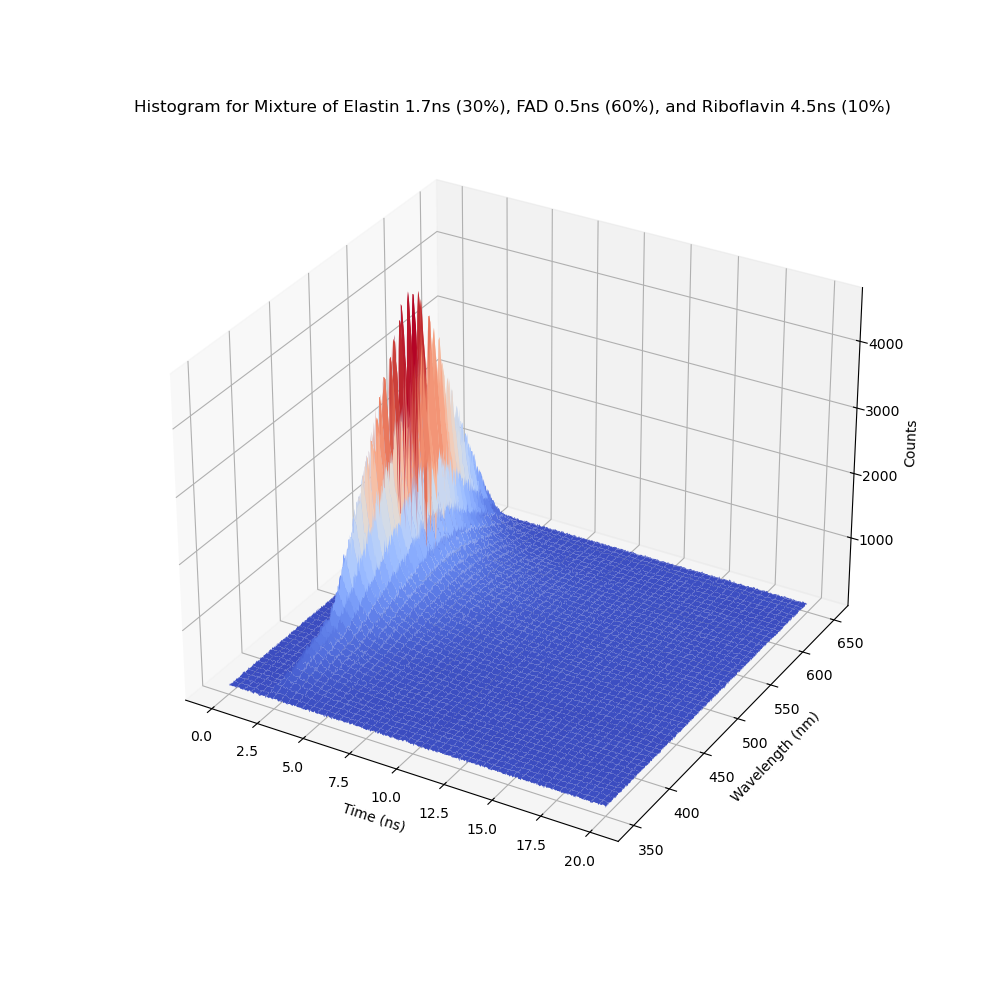

In [13]:
mixture = elastin_data + fad_data + riboflavin_data
spectral_sensitivity_matrix = elastin.get_spectral_sensitivity_matrix()
mixture_spectral_sensitivity = mixture * spectral_sensitivity_matrix
bias_matrix = elastin.bias.get_bias_matrix().astype(np.int64)
mixture_bias = mixture + bias_matrix
mixture_spectral_sensitivity += bias_matrix
elastin.plot_data(
    mixture_bias,
    name="Mixture of Elastin 1.7ns (30%), FAD 0.5ns (60%), and Riboflavin 4.5ns (10%)",
    time_range=(0, 20),
)

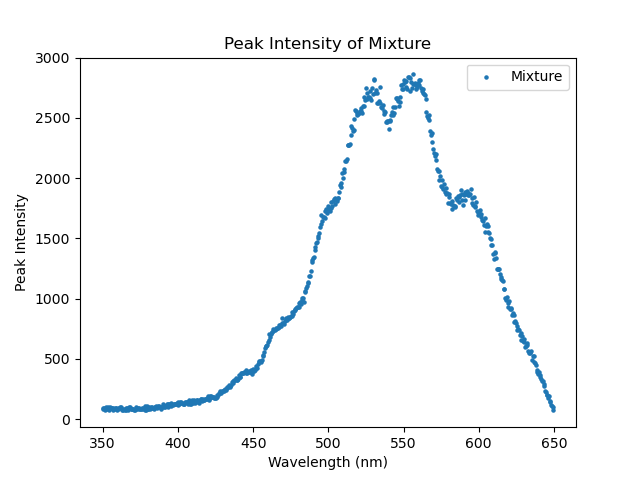

In [14]:
# plot mixture peak intensities
mixture_wavelengths, mixture_peaks = get_peak_intensity_per_channel(
    mixture_spectral_sensitivity,
    elastin.bias.get_intensity_matrix_indicies(),
    with_wavelengths=True,
)

plt.figure()
plt.scatter(mixture_wavelengths, mixture_peaks, s=5, label="Mixture")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Peak Intensity")
plt.title("Peak Intensity of Mixture")
plt.legend()
plt.show()

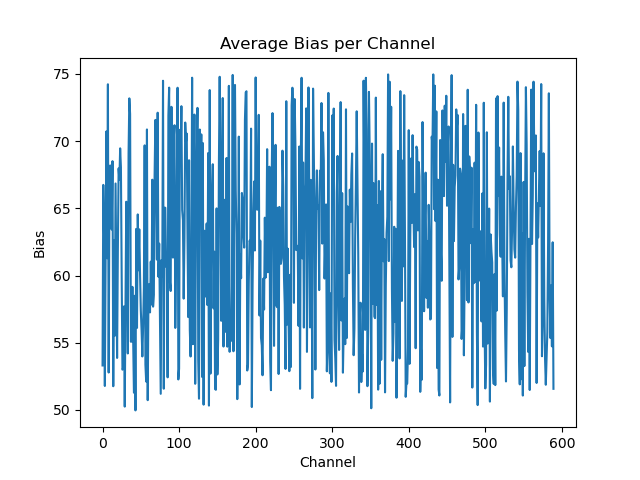

In [15]:
# bias_matrix = elastin.bias.get_bias_matrix().astype(np.int64)
# averaged_bias_per_channel = [
#     np.mean(bias_matrix[:, i]) for i in range(bias_matrix.shape[1])
# ]
averaged_bias_per_channel = np.mean(
    bias_matrix[
        elastin.bias.get_intensity_matrix_indicies()[
            0
        ] : elastin.bias.get_intensity_matrix_indicies()[1]
    ],
    axis=1,
)
plt.figure()
plt.plot(averaged_bias_per_channel)
plt.xlabel("Channel")
plt.ylabel("Bias")
plt.title("Average Bias per Channel")
plt.show()

/home/markus/code/fluoro-data-gen/scripts/../src/Tissue_Fluorophore.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  irf_wavelengths = torch.tensor(irf_emission_samples, device=device)


Shape of irf delay: torch.Size([6875000])
Shape of inverse cdf lifetime samples: torch.Size([6875000])
Missing indexes: set()
Wavelength channel indicies: tensor([   0,    0,    0,  ..., 1374, 1374, 1374])
Unique wavelength indcies 1375
Max irf intensity: 1060
Avg irf intensity: 980.9803636363637


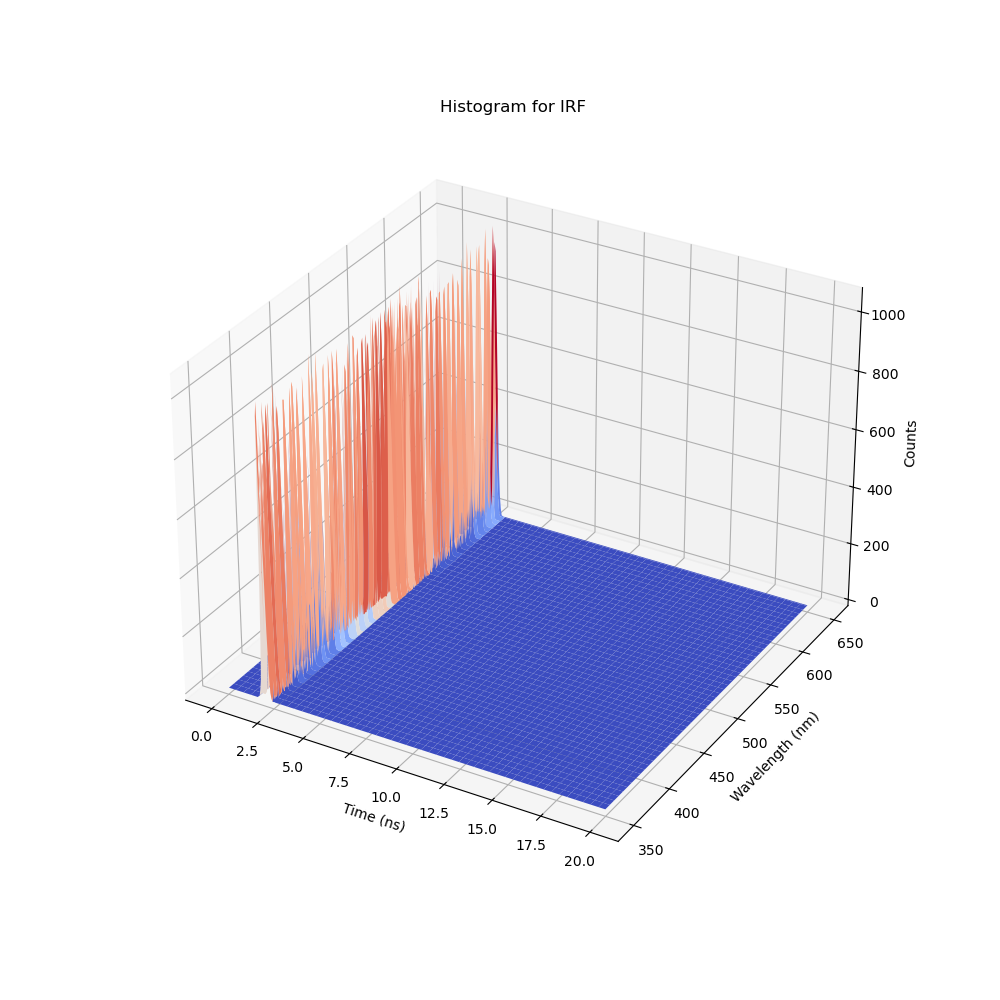

In [16]:
irf_wave = elastin.extract_irf_wave()
max_irf_intensity, avg_irf_intensity = get_max_and_average_peak_intensity_per_channel(
    irf_wave
)
print(f"Max irf intensity: {max_irf_intensity}")
print(f"Avg irf intensity: {avg_irf_intensity}")
elastin.plot_data(
    irf_wave, name="IRF", view_entire_spectral_range=False, time_range=(0, 20)
)

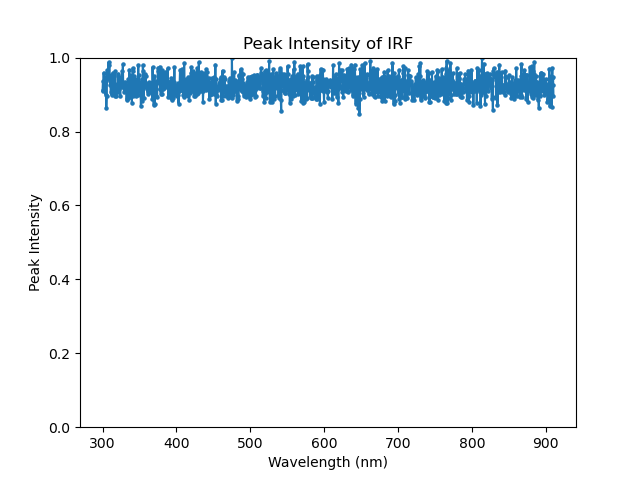

In [17]:
irf_wavelengths, irf_peak_intensities = get_peak_intensity_per_channel(
    irf_wave, (0, irf_wave.shape[1]), with_wavelengths=True
)

irf_peak_intensities = irf_peak_intensities / irf_peak_intensities.max()

# make a rolling average of the irf peak intensities
irf_peak_intensities_rolling = np.convolve(
    irf_peak_intensities, np.ones(5) / 5, mode="same"
)
plt.figure()
plt.scatter(irf_wavelengths, irf_peak_intensities, s=5)
plt.plot(irf_wavelengths, irf_peak_intensities)
# plt.plot(irf_wavelengths, irf_peak_intensities_rolling)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Peak Intensity")
plt.title("Peak Intensity of IRF")


plt.ylim(0, 1)
# plt.xlim(450, 650)

plt.show()

In [18]:
elastin_peak_info = np.array(list(zip(elastin_wavelengths, elastin_peaks_scaled)))
fad_peak_info = np.array(list(zip(fad_wavelengths, fad_peaks_scaled)))
riboflavin_peak_info = np.array(
    list(zip(riboflavin_wavelengths, riboflavin_peaks_scaled))
)

In [39]:
data_directory = "data/mixtures"
save_data("mixture-elastin-fad-riboflavin", mixture, irf_wave, data_directory)
save_data("mixture-elastin-fad-riboflavin-bias", mixture_bias, irf_wave, data_directory)
save_data(
    "mixture-elastin-fad-riboflavin-spectral-sensitivity",
    mixture_spectral_sensitivity,
    irf_wave,
    data_directory,
)
save_data("elastin", elastin_data, irf_wave, data_directory)
save_data("fad", fad_data, irf_wave, data_directory)
save_data("riboflavin", riboflavin_data, irf_wave, data_directory)
save_peak_intensities(
    "mixture-A-elastin",
    elastin_peak_info,
    data_directory,
)
save_peak_intensities(
    "mixture-A-fad",
    fad_peak_info,
    data_directory,
)
save_peak_intensities(
    "mixture-A-riboflavin",
    riboflavin_peak_info,
    data_directory,
)
save_bias_data("", bias_matrix, data_directory)